In [30]:
! pip install tabulate

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


In [20]:
import pandas as pd

llm_results = pd.read_json(f"eval_processed_parallel.json", lines=True)
#print(llm_results.iloc[0]['results']['input'])
llm_results['results'] = [[[movie[0].removeprefix("Movie name: ")] for movie in m_list['rating']] for m_list in llm_results['results']]
print(llm_results.iloc[0]['results'])

eval_dataset = pd.read_json(f"TTE_with_IO_eval.json")
#print(eval_dataset.iloc[0]['input'])
#print(eval_dataset.iloc[0]['output'])

def split_list(text, start_token, end_token):
    phrase = text.split(start_token + "\n")
    movie_list = phrase[1].split("\n" + end_token)[0]
    movie_list = movie_list.split("\n")
    for i, movie in enumerate(movie_list):
        movie_list[i] = movie.split("\t")
    return movie_list

eval_dataset['user_out_list'] = [split_list(x, "%% START RECOMMENDED LIST %%", "%% END LIST %%") for x in eval_dataset['output']]
eval_dataset['user_out_list'] = [[[movie[0].removeprefix("Movie name: ")] for movie in m_list] for m_list in eval_dataset['user_out_list']]
print(eval_dataset.iloc[0]['user_out_list'])

[['Tarzan (1999)'], ['Shanghai Noon (2000)'], ['Antz (1998)'], ['Hunchback of Notre Dame, The (1996)'], ['Hercules (1997)'], ['Mulan (1998)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Close Shave, A (1995)'], ["Bug's Life, A (1998)"], ['Hackers (1995)'], ['Hideaway (1995)'], ['Toy Story 2 (1999)'], ['Hudsucker Proxy, The (1994)'], ['Mulan (1998)'], ['Rosencrantz and Guildenstern Are Dead (1990)'], ['Shanghai Noon (2000)'], ['Mulan (1998)'], ['Hercules (1997)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Mulan (1998)'], ['Toy Story 2 (1999)'], ['Antz (1998)'], ['Hackers (1995)'], ['Hunchback of Notre Dame, The (1996)'], ["Bug's Life, A (1998)"], ['Toy Story (1995)'], ['Hudsucker Proxy, The (1994)'], ['Shanghai Noon (2000)'], ['Rosencrantz and Guildenstern Are Dead (1990)'], ['Mulan (1998)'], ['Hercules (1997)'], ['Beauty and the Beast (1991)'], ['Toy Story (1995)'], ['Antz (1998)'], ['Mulan (1998)'], ['Close Shave, A (1995)'], ['Hunchback of Notre Dame, The

In [21]:
pd_data = pd.DataFrame()
pd_data["sorted_candidates"] = eval_dataset['user_out_list']
pd_data["relevant_movies"] = pd_data["sorted_candidates"].apply(lambda data: data[:10])
pd_data["sorted_rating"] = llm_results['results']
print(pd_data.head(1))


                                   sorted_candidates  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                     relevant_movies  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                       sorted_rating  
0  [[Tarzan (1999)], [Shanghai Noon (2000)], [Ant...  


In [34]:
from tabulate import tabulate
import math

avgs = [[0 for n_rel in range(10)] for k_i in [1,5,10]]

for k_i in [1,5,10]:
    for n_rel in range(10):
        
        def hit_rate_at_k(predicted_ranking, relevant_items, k):
            top_k = set(predicted_ranking[:k])
            return 1 if top_k.intersection(relevant_items[:n_rel+1]) else 0
        
        def hit_rate_for_row(row):
            ratings = [movie for [movie] in row['sorted_rating']]
            rel_item = [movie for [movie] in row["relevant_movies"]]
            return hit_rate_at_k(ratings, rel_item, k_i)
        
        pd_data["hit_rate"] = pd_data.apply(hit_rate_for_row, axis=1)
        avg = pd_data["hit_rate"].mean()
        avgs[int(k_i/5)][n_rel] = math.trunc(avg * 10_000) / 10_000
        # print(avg)

# print(avgs)

print(tabulate(
    avgs,
    headers=[f"#RI {n+1}" for n in range(10)],
    showindex=[f"HitRate@{k}" for k in [1,5,10]],
    tablefmt="grid"
))

+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
|            |   #RI 1 |   #RI 2 |   #RI 3 |   #RI 4 |   #RI 5 |   #RI 6 |   #RI 7 |   #RI 8 |   #RI 9 |   #RI 10 |
+============+=========+=========+=========+=========+=========+=========+=========+=========+=========+==========+
| HitRate@1  |  0.8293 |  0.8801 |  0.8801 |  0.8801 |  0.8801 |  0.8851 |  0.8851 |  0.8851 |  0.8855 |    0.886 |
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| HitRate@5  |  0.8451 |  0.9751 |  1      |  1      |  1      |  1      |  1      |  1      |  1      |    1     |
+------------+---------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| HitRate@10 |  0.9365 |  0.9961 |  1      |  1      |  1      |  1      |  1      |  1      |  1      |    1     |
+------------+---------+---------+---------+---------+---------+--------

In [38]:
import numpy as np

def dcg_at_k(relevances, k):
    relevances = np.array(relevances[:k])
    return np.sum(relevances / np.log2(np.arange(2, k + 2)))

def ndcg_at_k(predicted_ranking, relevance_dict, k):
    rel_pred = [relevance_dict.get(item, 0) for item in predicted_ranking]
    dcg = dcg_at_k(rel_pred, k)
    ideal_rel = sorted(relevance_dict.values(), reverse=True)
    idcg = dcg_at_k(ideal_rel, k)
    return dcg / idcg if idcg > 0 else 0

def ndcg_for_row(row):
    predicted = [movie for [movie] in row['sorted_rating']]
    relevance_dict = {movie:1 for [movie] in row["sorted_candidates"]}  # Others default to 0
    k = 10
    ndcg = ndcg_at_k(predicted, relevance_dict, k)
    return ndcg

pd_data["ndcg"] = pd_data.apply(ndcg_for_row, axis=1)

#ndcg_for_row(pd_data.loc[0])
print(pd_data.head(1))
avg = pd_data["ndcg"].mean()
print(avg)

                                   sorted_candidates  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                     relevant_movies  \
0  [[Tarzan (1999)], [Close Shave, A (1995)], [An...   

                                       sorted_rating  hit_rate  ndcg  
0  [[Tarzan (1999)], [Shanghai Noon (2000)], [Ant...         1   1.0  
0.9820444261347765


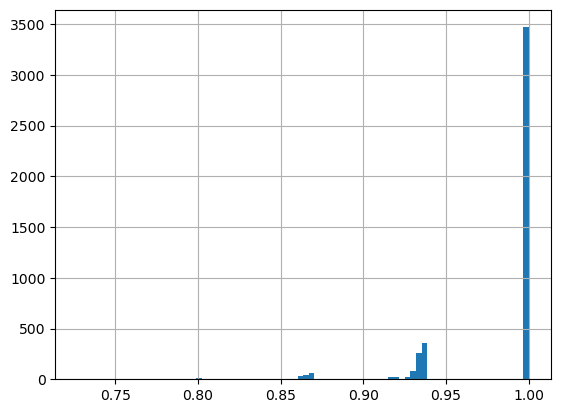

In [53]:
import matplotlib.pyplot as plt

pd_data['ndcg'].hist(bins=80)
plt.show()

In [47]:
import pandas as pd
import numpy as np
from itertools import chain
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings('once')

# Load data (adjust paths as needed)
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', names=['user_id', 'movie_id', 'rating', 'timestamp'], engine='python')
users = pd.read_csv('ml-1m/users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip'], engine='python')
movies = pd.read_csv('ml-1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='latin-1')

#pd_data: 'candidates/rating':[['title', rating], ...]

user_ratings = movies.merge(ratings)
user_ratings["popularity"] = (user_ratings["rating"] > 2).astype(int)


In [48]:
summary_llm_rating = (
    user_ratings.groupby("title", as_index=False)
      .agg(
          total_rating=("rating", "sum"),
          total_popularity=("popularity", "sum"),
          n_rows=("rating", "size"),
          avg_rating=("rating", "mean")
      )
)
#########################  I'm using all the ratings on porpuse  #########################

In [49]:
summary_llm_rating.head(10)

,title,total_rating,total_popularity,n_rows,avg_rating
0,"$1,000,000 Duck (1971)",112,26,37,3.027027
1,'Night Mother (1986),236,56,70,3.371429
2,'Til There Was You (1997),140,27,52,2.692308
3,"'burbs, The (1989)",882,198,303,2.910891
4,...And Justice for All (1979),739,185,199,3.713568
5,1-900 (1994),5,1,2,2.500000
6,10 Things I Hate About You (1999),2396,591,700,3.422857
7,101 Dalmatians (1961),2032,491,565,3.596460
8,101 Dalmatians (1996),1109,259,364,3.046703
9,12 Angry Men (1957),2646,598,616,4.295455


In [50]:
max_popularity = summary_llm_rating["total_popularity"].max()
pop_vs_ccdd = [[x,(summary_llm_rating["total_popularity"]>x).sum()] for x in range(max_popularity)]


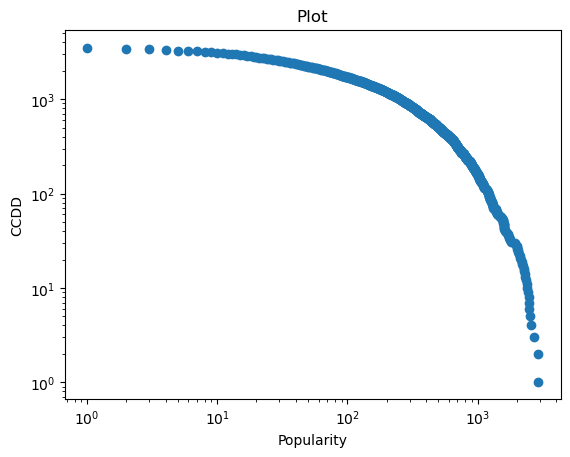

[np.int64(3628), np.int64(3509), np.int64(3421), np.int64(3358), np.int64(3307), np.int64(3272), np.int64(3235), np.int64(3202), np.int64(3160), np.int64(3123), np.int64(3091), np.int64(3058), np.int64(3028), np.int64(3006), np.int64(2975), np.int64(2944), np.int64(2904), np.int64(2866), np.int64(2843), np.int64(2805), np.int64(2779), np.int64(2756), np.int64(2730), np.int64(2713), np.int64(2686), np.int64(2661), np.int64(2639), np.int64(2615), np.int64(2598), np.int64(2573), np.int64(2558), np.int64(2538), np.int64(2518), np.int64(2501), np.int64(2477), np.int64(2460), np.int64(2443), np.int64(2423), np.int64(2407), np.int64(2390), np.int64(2374), np.int64(2349), np.int64(2338), np.int64(2322), np.int64(2300), np.int64(2285), np.int64(2270), np.int64(2254), np.int64(2238), np.int64(2223), np.int64(2212), np.int64(2197), np.int64(2189), np.int64(2174), np.int64(2160), np.int64(2150), np.int64(2140), np.int64(2124), np.int64(2118), np.int64(2108), np.int64(2090), np.int64(2080), np.int6

In [51]:
import matplotlib.pyplot as plt
x_pop, y_ccdd = zip(*pop_vs_ccdd)

def filter_duplicate(x_pop,y_ccdd):
    new_x = []
    new_y = []
    for i,x in enumerate(x_pop):
        if i == 0:
            new_x.append(x)
            new_y.append(y_ccdd[i])
        else:
            if y_ccdd[i] < y_ccdd[i-1]:
                new_x.append(x)
                new_y.append(y_ccdd[i])
    return new_x, new_y


x_pop, y_ccdd = filter_duplicate(x_pop, y_ccdd)

plt.scatter(x_pop, y_ccdd)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Popularity")
plt.ylabel("CCDD")
plt.title("Plot")
plt.show()
print(y_ccdd)
print(x_pop)

836


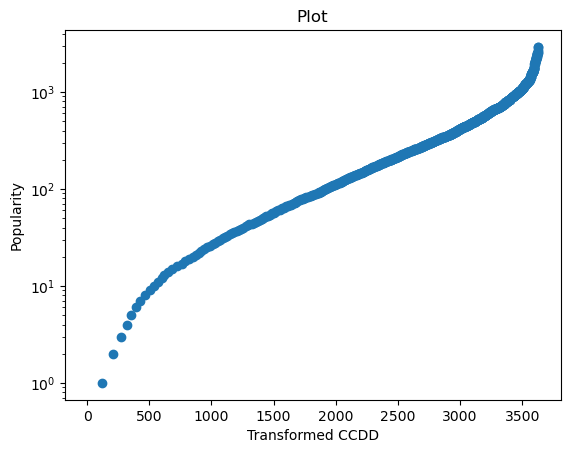

[0, np.int64(119), np.int64(207), np.int64(270), np.int64(321), np.int64(356), np.int64(393), np.int64(426), np.int64(468), np.int64(505), np.int64(537), np.int64(570), np.int64(600), np.int64(622), np.int64(653), np.int64(684), np.int64(724), np.int64(762), np.int64(785), np.int64(823), np.int64(849), np.int64(872), np.int64(898), np.int64(915), np.int64(942), np.int64(967), np.int64(989), np.int64(1013), np.int64(1030), np.int64(1055), np.int64(1070), np.int64(1090), np.int64(1110), np.int64(1127), np.int64(1151), np.int64(1168), np.int64(1185), np.int64(1205), np.int64(1221), np.int64(1238), np.int64(1254), np.int64(1279), np.int64(1290), np.int64(1306), np.int64(1328), np.int64(1343), np.int64(1358), np.int64(1374), np.int64(1390), np.int64(1405), np.int64(1416), np.int64(1431), np.int64(1439), np.int64(1454), np.int64(1468), np.int64(1478), np.int64(1488), np.int64(1504), np.int64(1510), np.int64(1520), np.int64(1538), np.int64(1548), np.int64(1558), np.int64(1571), np.int64(1581)

In [52]:
transformed_ccdd = []
n = len(x_pop)
print(n)
for i in range(n):
    if i == 0:
        transformed_ccdd.append(0)
    else:
        new_value = transformed_ccdd[i-1]+y_ccdd[i-1]-y_ccdd[i]
        transformed_ccdd.append(new_value)
        #print(new_value)

plt.scatter(transformed_ccdd, x_pop)
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Popularity")
plt.xlabel("Transformed CCDD")
plt.title("Plot")
plt.show()
print(transformed_ccdd,x_pop)